:https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf

In [10]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.16.1


In [11]:
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.9.0


In [12]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# csv_file_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle_Projects/House Prices/data/train.csv"

In [13]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Masic command being used in Jupyter Notebooks to display plots inline, directly below the codde cells that produce them.
%matplotlib inline

In [14]:
data = pd.read_csv('./data/train.csv')
data.head(5)

#We will drop the Id column as it is not necessary for model training
data = data.drop('Id', axis=1)
if 'Id' in data.columns:
    print("Column 'Id' exists in the dataset.")
else:
    print("Column 'Id' does not exist in the dataset.")

Column 'Id' does not exist in the dataset.


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/var/folders/ks/h24y33vx0jxg8b9y0r2hqqsw0000gn/T/ipykernel_43474/1334655157.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['SalePrice'], color='purple', bins=100, hist_kws={'alpha': 0.4});


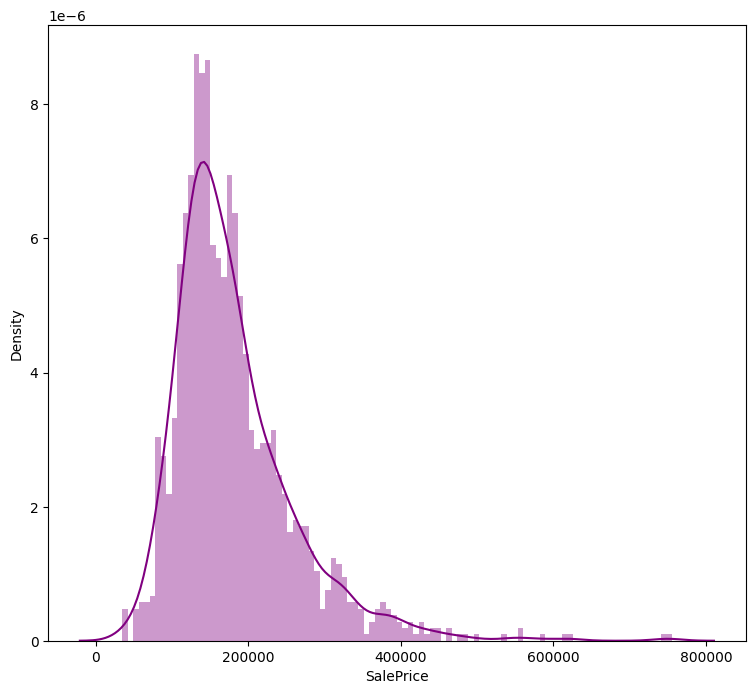

In [16]:
print(data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data['SalePrice'], color='purple', bins=100, hist_kws={'alpha': 0.4});


List all the types of tdata from our dataset and select only the numerical ones

In [17]:
list(set(data.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [18]:
#Exclude dtype('0') to make the numerical dataset
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


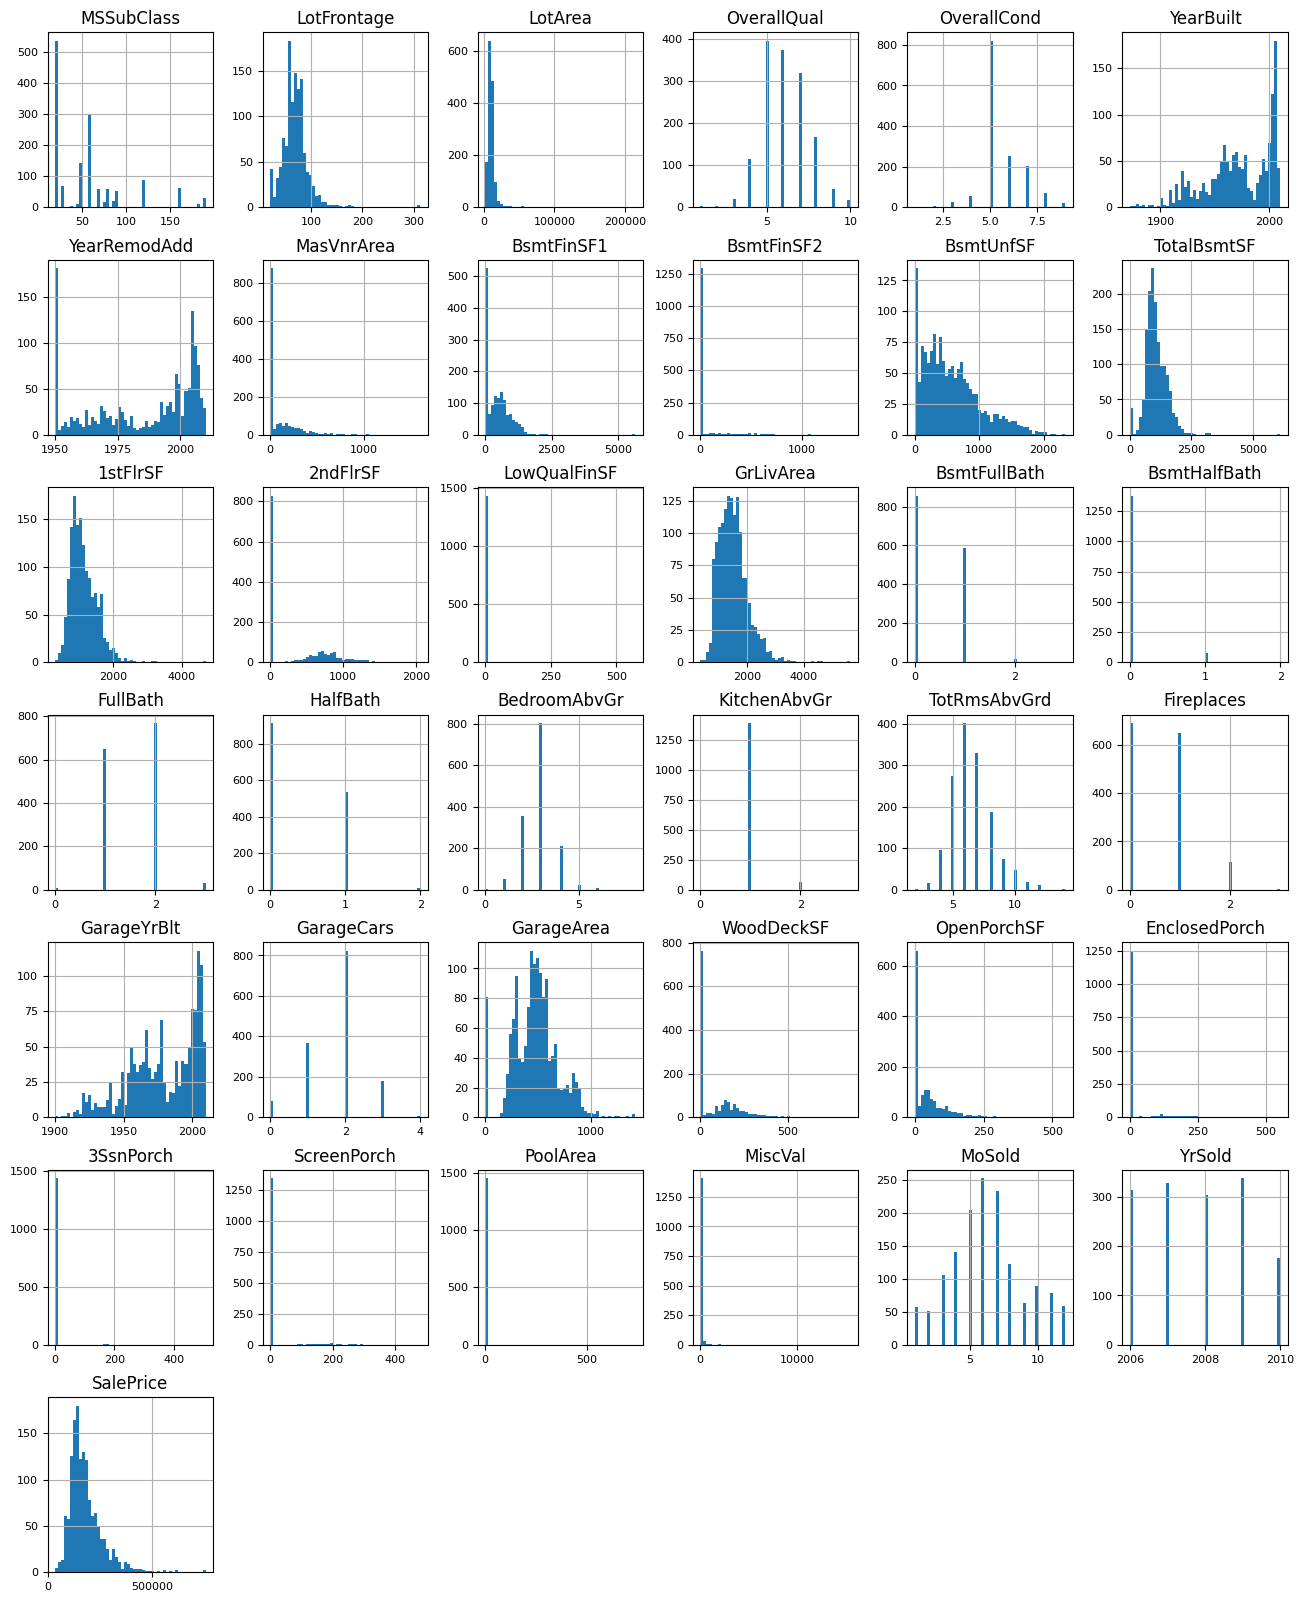

In [19]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

In [20]:
# from sklearn.model_selection import train_test_split

# train_data, valid_data = train_test_split(data, data[SalePrice] , test_size=0.3, shuffle=True)
# print("{} examples in training, {} examples in testing.".format(
#     len(train_data), len(valid_data)))
# TensorFlow Decision Forests requires its own format of dataset so we do as follow... vs the one I used for class.
# There are ways to do this way vs need extra steps to prepare data. Also since we are using specific library TFDF, we want to follow the recommended way.

import numpy as np

def split_dataset(data, test_ratio=0.25):
  test_indices = np.random.rand(len(data)) < test_ratio
  return data[~test_indices], data[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(data)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1124 examples in training, 336 examples in testing.


In [21]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

2024-05-20 20:27:20.816584: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-05-20 20:27:20.816654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 20:27:20.816667: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 20:27:20.816721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 20:27:20.816748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [23]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /var/folders/ks/h24y33vx0jxg8b9y0r2hqqsw0000gn/T/tmp_moiowkv as temporary training directory


In [24]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

Use /var/folders/ks/h24y33vx0jxg8b9y0r2hqqsw0000gn/T/tmpzsh5ji9p as temporary training directory


In [25]:
rf.fit(x=train_ds)

Reading training dataset...


2024-05-20 20:27:22.581082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:01.834063. Found 1124 examples.
Training model...
Model trained in 0:00:00.481478
Compiling model...


[INFO 24-05-20 20:27:23.2342 CDT kernel.cc:1233] Loading model from path /var/folders/ks/h24y33vx0jxg8b9y0r2hqqsw0000gn/T/tmpzsh5ji9p/model/ with prefix 7e87b061caf74442
[INFO 24-05-20 20:27:23.3334 CDT decision_forest.cc:734] Model loaded with 300 root(s), 106554 node(s), and 72 input feature(s).
[INFO 24-05-20 20:27:23.3334 CDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-05-20 20:27:23.3335 CDT kernel.cc:1061] Use fast generic engine


Model compiled.


In [26]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

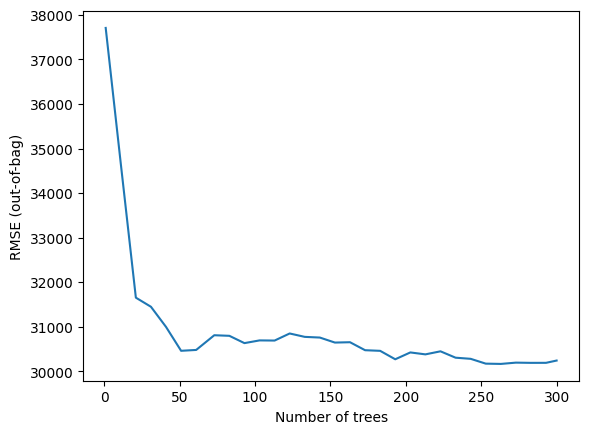

In [27]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [28]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1124, accuracy=None, loss=None, rmse=30243.23267404203, ndcg=None, aucs=None, auuc=None, qini=None)

In [29]:
evaluation = rf.evaluate(x=valid_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00
loss: 0.0000


In [30]:
# Variable importances generally indicate how much a feature contributes to the model predictions or quality.
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [31]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 121.0),
 ("ExterQual" (4; #22), 51.0),
 ("GarageCars" (1; #32), 45.0),
 ("Neighborhood" (4; #59), 30.0),
 ("GrLivArea" (1; #38), 17.0),
 ("BsmtQual" (4; #14), 11.0),
 ("KitchenQual" (4; #44), 7.0),
 ("TotalBsmtSF" (1; #73), 7.0),
 ("GarageArea" (1; #31), 6.0),
 ("YearBuilt" (1; #76), 2.0),
 ("BsmtFinSF1" (1; #8), 1.0),
 ("FullBath" (1; #29), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

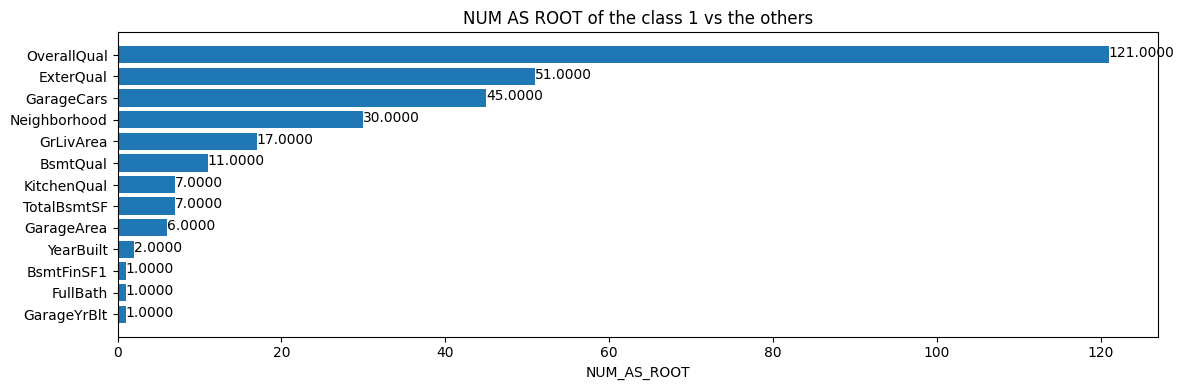

In [32]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [36]:
test_file_path = "./data/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 0s 54ms/step


,Id,SalePrice
0,1461,126676.000000
1,1462,153280.828125
2,1463,179210.062500
3,1464,182466.203125
4,1465,197245.031250


In [38]:
sample_submission_df = pd.read_csv('./data/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('./data/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 47ms/step


,Id,SalePrice
0,1461,126676.000000
1,1462,153280.828125
2,1463,179210.062500
3,1464,182466.203125
4,1465,197245.031250


In [39]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB
